# Hate Speech Classification Model

By: Antonio Villarreal, Taise Miyazumi, Lucas Skaf

The goal of this project is to develop a multimodal machine learning model to help and support the fight **against** any form of hate speech. Additionally, this project was developed for a class assignment.

**Disclaimer: All the content (images and captions) used in this model and included in the dataset are not supported and do not represent in any shape or form the ideas and opinions of the developers of this project.**

In [ ]:
# !pip install pandas matplotlib Pillow requests nltk scikit-learn keras tensorflow

In [ ]:
 ! pip install -q kaggle
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json
 ! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                 title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023               Data Science Salaries 2023  💸                25KB  2023-04-13 09:55:16           6999        173  1.0              
salvatorerastelli/spotify-and-youtube               Spotify and Youtube                           9MB  2023-03-20 15:43:25          12105        415  1.0              
iammustafatz/diabetes-prediction-dataset            Diabetes prediction dataset                 734KB  2023-04-08 06:11:45           3673         59  1.0              
shawkyelgendy/furniture-price-prediction            Furniture Price Prediction                   81K

In [ ]:
! kaggle datasets download -d victorcallejasf/multimodal-hate-speech

100% 5.96G/5.97G [00:46<00:00, 196MB/s]
100% 5.97G/5.97G [00:46<00:00, 139MB/s]


In [ ]:
! unzip multimodal-hate-speech.zip -d dataset

In [ ]:
import json
import os
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Markdown
import requests
from io import BytesIO
from collections import defaultdict
import re
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
import tensorflow as tf
import keras.preprocessing.image
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
DIRECTORY = '/content'
DATA = DIRECTORY + '/dataset'
IMAGES = DATA + '/img_resized'
CAPTIONS = DATA + '/img_txt'
DISTRIBUTION = DATA + '/splits'
JSON = DATA + '/MMHS150K_GT.json'

In [ ]:
TESTING = DISTRIBUTION + "/test_ids.txt"
TRAINING = DISTRIBUTION + "/train_ids.txt"
VALIDATION = DISTRIBUTION + "/val_ids.txt"

In [ ]:
TRAIN_CSV = DIRECTORY + "/train.csv"
TEST_CSV = DIRECTORY + "/test.csv"
VALID_CSV = DIRECTORY + "/valid.csv"

In [ ]:
CONVERSION = {0: "NotHate", 1: "Racist", 2: "Sexist", 3: "Homophobe", 4: "Religion", 5: "OtherHate"}

## Data Analysis

Example Tweets

In [ ]:
def print_image_and_caption(id):
    # Define the paths to the image and caption files
    image_path = os.path.join(IMAGES, f"{id}.jpg")
    caption_path = os.path.join(CAPTIONS, f"{id}.json")

    # Load the caption from the JSON file
    with open(caption_path, "r") as f:
        caption_data = json.load(f)
    caption = caption_data["img_text"]

    # Open and show the image
    with Image.open(image_path) as img:
        display(img)

    # Print the caption as Markdown for formatting
    display(Markdown(f"**Caption:** {caption}"))
    
    with open(JSON, "r") as f:
        data = json.load(f)

    for id_, contents in data.items():
      if id_ == str(id):
          labels_str = contents["labels_str"]
          print(labels_str)
          break
    else:
        print(f"No matching ID '{str(id)}' found in the JSON file.")

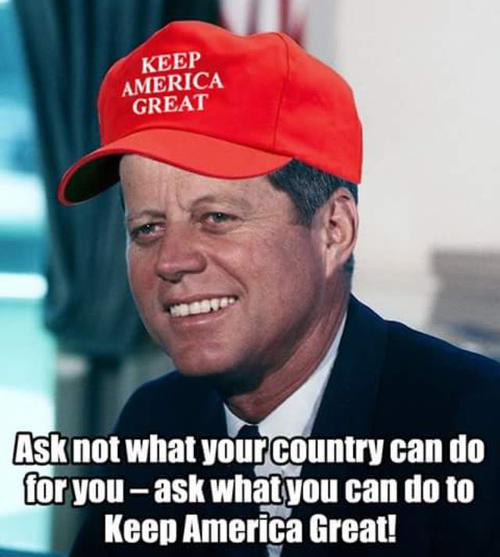

**Caption:** KEEP AMERICA GREAT Asknot what yourcountry can do for you-ask whatyou can do to Keep America Great! 

['OtherHate', 'NotHate', 'NotHate']


In [ ]:
print_image_and_caption(1024023264497152001)

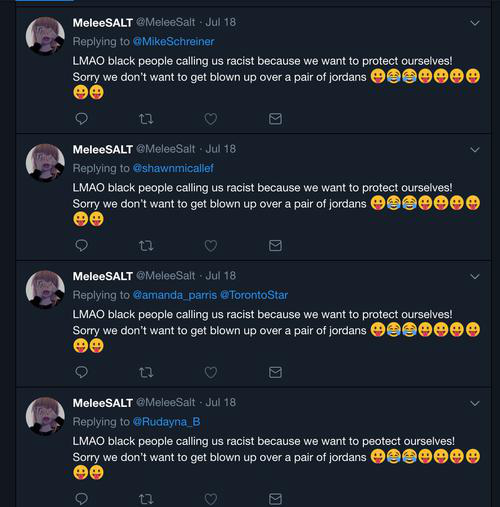

**Caption:** MeleeSALT MeleeSalt Jul 18 Replying to @MikeSchreiner LMAO black people calling us racist because we want to protect ourselves! Sorry we don't want to get blown up over a pair of jordanseee MeleeSALT MeleeSalt Jul 18 Replying to @shawnmicallef LMAO black people calling us racist because we want to protect ourselves! Sorry we don't want to get blown up over a pair of jordanseeee ta. MeleeSALT @MeleeSalt Jul 18 Replying to @amanda parris @TorontoStar LMAO black people calling us racist because we want to protect ourselves! Sorry we don't want to get blown up over a pair of jordanseeee MeleeSALT MeleeSalt Jul 18 Replying to @Rudayna B LMAO black people calling us racist because we want to peotect ourselves! Sorry we don't want to get blown up over a pair of jordans eee ta 

['OtherHate', 'Racist', 'Racist']


In [ ]:
print_image_and_caption(1024122734257872896)

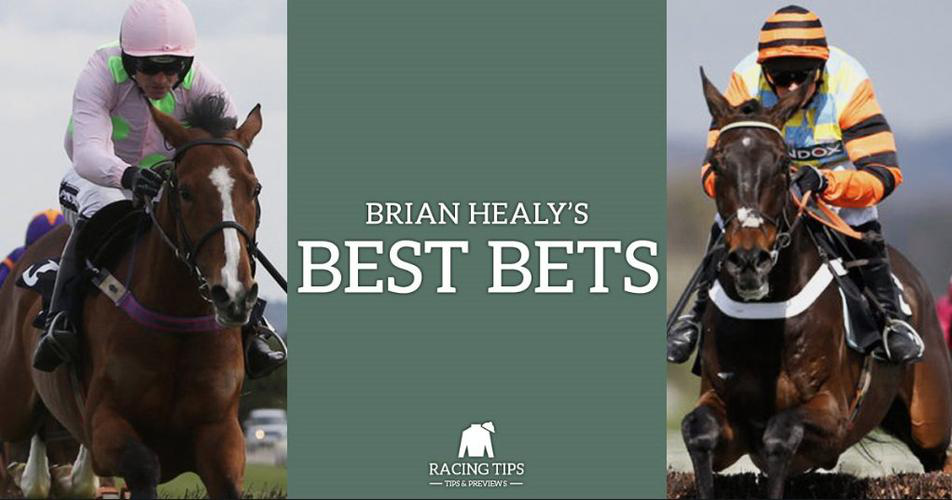

**Caption:** BRIAN HEALY'S BEST BETS RACING TIPS TIPS&PREVIEWS 

['NotHate', 'NotHate', 'NotHate']


In [ ]:
print_image_and_caption(1025083811946815488)

Testing, Training, and Validation Distribution

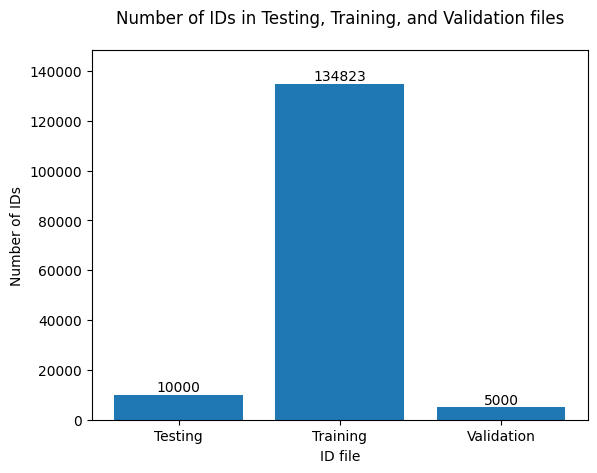

In [ ]:
# Define the labels for the x-axis
x_labels = ["Testing", "Training", "Validation"]

# Initialize a dictionary to store the number of IDs in each file
id_counts = {}

# Loop through the filepaths and count the number of IDs in each file
for filepath in [TESTING, TRAINING, VALIDATION]:
    with open(filepath, "r") as f:
        ids = f.read().splitlines()
        filename = os.path.basename(filepath)
        id_counts[filename] = len(ids)

# Plot a bar chart of the ID counts
plt.bar(range(len(id_counts)), list(id_counts.values()), align="center")
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel("ID file")
plt.ylabel("Number of IDs")
plt.title("Number of IDs in Testing, Training, and Validation files", y=1.05)
plt.ylim(0, max(id_counts.values()) * 1.1)

# Add labels to the bars
for i, count in enumerate(id_counts.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
# Print the ID counts for reference
for filename, count in id_counts.items():
    print(f"{filename}: {count}")

test_ids.txt: 10000
train_ids.txt: 134823
val_ids.txt: 5000


In [ ]:
total_count = sum(id_counts.values())
print(f"Total number of data points: {total_count}")

Total number of data points: 149823


Training Dataset Hate Label Distribution

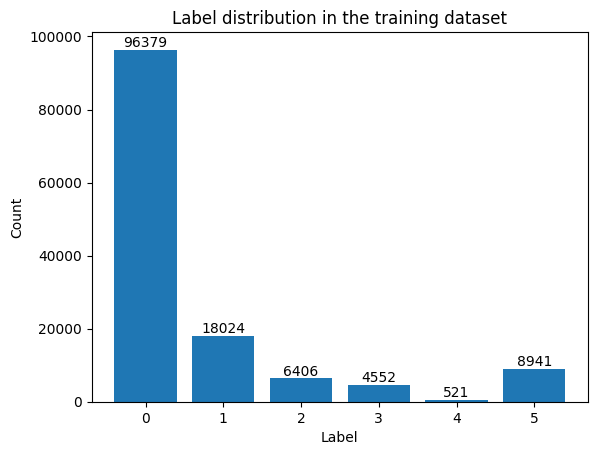

In [ ]:
# Load the IDs from the txt file
with open(TRAINING, "r") as f:
    ids = f.read().splitlines()

# Load the data from the JSON file
with open(JSON, "r") as f:
    data = json.load(f)

# Create an array to store the counts for each label
label_counts = np.zeros(6)

# Count the number of occurrences for each label in the dataset
for id in ids:
    label = data[id]['labels'][0]
    label_counts[label] += 1

# Plot the distribution
labels = ['0', '1', '2', '3', '4', '5']
plt.bar(labels, label_counts)
plt.title("Label distribution in the training dataset")
plt.xlabel("Label")
plt.ylabel("Count")

# Add numerical labels for each bar
for i, count in enumerate(label_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

Testing Dataset Hate Label Distribution

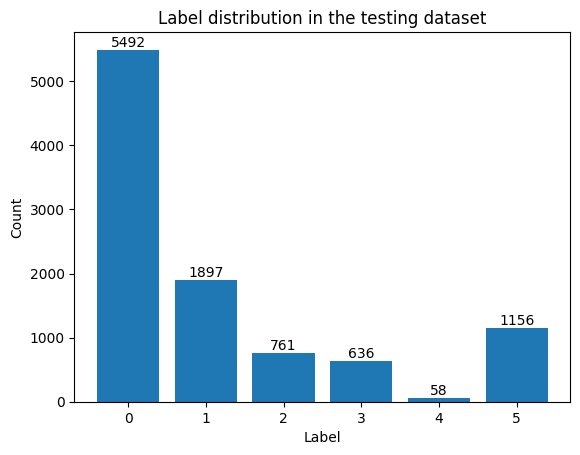

In [ ]:
# Load the IDs from the txt file
with open(TESTING, "r") as f:
    ids = f.read().splitlines()

# Load the data from the JSON file
with open(JSON, "r") as f:
    data = json.load(f)

# Create an array to store the counts for each label
label_counts = np.zeros(6)

# Count the number of occurrences for each label in the dataset
for id in ids:
    label = data[id]['labels'][0]
    label_counts[label] += 1

# Plot the distribution
labels = ['0', '1', '2', '3', '4', '5']
plt.bar(labels, label_counts)
plt.title("Label distribution in the testing dataset")
plt.xlabel("Label")
plt.ylabel("Count")

# Add numerical labels for each bar
for i, count in enumerate(label_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

Validation Dataset Hate Label Distribution

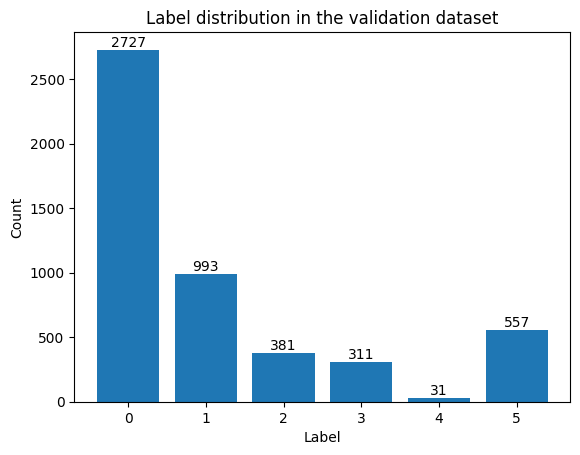

In [ ]:
# Load the IDs from the txt file
with open(VALIDATION, "r") as f:
    ids = f.read().splitlines()

# Load the data from the JSON file
with open(JSON, "r") as f:
    data = json.load(f)

# Create an array to store the counts for each label
label_counts = np.zeros(6)

# Count the number of occurrences for each label in the dataset
for id in ids:
    label = data[id]['labels'][0]
    label_counts[label] += 1

# Plot the distribution
labels = ['0', '1', '2', '3', '4', '5']
plt.bar(labels, label_counts)
plt.title("Label distribution in the validation dataset")
plt.xlabel("Label")
plt.ylabel("Count")

# Add numerical labels for each bar
for i, count in enumerate(label_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

Hate Label Distribution

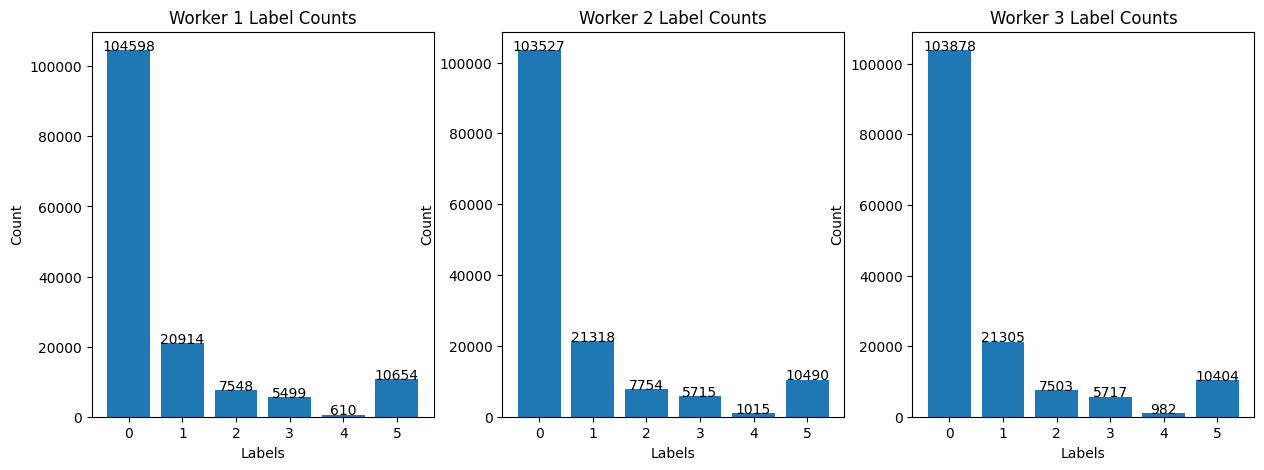

In [ ]:
# Open JSON file
with open(JSON) as f:
    data = json.load(f)

# Count labels for each worker
counts = defaultdict(int)
for id in data:
    for i, label in enumerate(data[id]['labels']):
        counts[(i+1, label)] += 1

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot each worker's label counts
for i in range(3):
    worker_counts = [counts[(i+1, j)] for j in range(6)]
    labels = ['0', '1', '2', '3', '4', '5']
    x = range(len(labels))
    y = worker_counts
    axs[i].bar(x, y)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(labels)
    axs[i].set_title(f'Worker {i+1} Label Counts')
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel('Labels')
    plt.ylabel('Count')
    for j, v in enumerate(y):
        axs[i].text(j, v+5, str(v), ha='center')

# Display the charts
plt.show()

0 - NotHate, 1 - Racist, 2 - Sexist, 3 - Homophobe, 4 - Religion, 5 - OtherHate

## Preprocessing

Cleaning (with Tokenization)

In [ ]:
def clean_text(text):
  text = str(text)

  # Remove links
  text = re.sub(r'https?://\S+', '', text)

  # Remove emojis
  text = re.sub(r'[^\w\s]', '', text)

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  text = ' '.join([word for word in text.split() if word not in stop_words])

  # Tokenize
  tokens = nltk.word_tokenize(text)

  # Remove special characters
  tokens = [re.sub(r"[^\w\s]", "", token) for token in tokens]

  # Remove numbers
  tokens = [re.sub(r'\d', '', token) for token in tokens]

  # Lowercase
  tokens = [token.lower() for token in tokens]

  # Lemmatize
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  # Join the tokens back into a string
  text = ' '.join(tokens)

  return text

In [ ]:
def tokanize(text):
  return text.lower().split()

In [ ]:
text = clean_text('testing this function with other examples')
print(tokanize(text))

['testing', 'function', 'example']


Cleaning (without Tokenization)

In [ ]:
# # Clean the text
# def clean_text(text):
#   text = str(text)

#   # Remove links
#   text = re.sub(r'https?://\S+', '', text)

#   # Remove emojis
#   text = re.sub(r'[^\w\s]', '', text)

#   # Remove stopwords
#   stop_words = set(stopwords.words('english'))
#   text = ' '.join([word for word in text.split() if word not in stop_words])

#   # Remove special characters
#   text = re.sub(r"[^\w\s]", "", text)

#   # Remove numbers
#   text = re.sub(r'\d', '', text)

#   # Lowercase
#   text = text.lower()

#   # Lemmatize
#   lemmatizer = WordNetLemmatizer()
#   text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

#   return text

**Train.csv**

In [ ]:
# Read the IDs from the train_ids.txt file
with open(TRAINING, 'r') as f:
    train_ids = set(line.strip() for line in f)

# Load the labels from the JSON file
with open(JSON, 'r') as f:
    data = json.load(f)

# Create a list to store the ID, caption, and labels for each JSON file
id_caption_label_list = []

# Loop through each JSON file in the directory
for filename in os.listdir(CAPTIONS):
    if filename.endswith(".json"):
        with open(os.path.join(CAPTIONS, filename), 'r') as f:
            # Load the JSON data from the file
            json_data = json.load(f)
            # Extract the ID and caption from the JSON data
            id = os.path.splitext(filename)[0]
            caption = json_data["img_text"]
            # Extract the labels from the data JSON
            if id in data:
                labels = data[id]['labels']
                label1 = labels[0] if len(labels) > 0 else ""
                label2 = labels[1] if len(labels) > 1 else ""
                label3 = labels[2] if len(labels) > 2 else ""
            else:
                label1 = ""
                label2 = ""
                label3 = ""
            # Add the ID, caption, and labels to the list if the ID is in train_ids
            if id in train_ids:
                image_filepath = IMAGES + "/" + f"{id}.jpg"
                id_caption_label_list.append((id, caption, (label1), (label2), (label3), image_filepath))

# Write the ID, caption, and labels list to a CSV file
with open(TRAIN_CSV, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "Caption", "Label 1", "Label 2", "Label 3", "Image Filepath"])
    writer.writerows(id_caption_label_list)

In [ ]:
df = pd.read_csv(TRAIN_CSV)

Original Captions

In [ ]:
df.head(20)

ID                                            Caption  \
0   1115350906822844416            ervi eturns Spring it on Spring it on!    
1   1109249523371499520                E'S FRIDAY 08:15:29 MAR 22 2019 PL    
2   1108403826162307072  RJAYYEEE'S TUESDAY P.M. 26:17 22 PLAY MAR 19 2...   
3   1115118179108446208  jaycritchsintern "Did you réally think l would...   
4   1109377459839881216  簝令ㄐ庇.alpl 1:43 e Now firmed up yet Nice old na...   
5   1037124974182580224                                             IDIOT    
6   1110196052106211329  Sky NEWS Va We like women. We wanna empower wo...   
7   1108020575220518912                       EVERYONE LOSES' THEIR MINDS    
8   1057686982871207936         nevaloore Ent ENVY PROD. BY EDDEY K BEATZ    
9   1109544210162692096                           Ktsmg head 12h ago CHAT    
10  1105383522167074817           0:03 / 0:03 ロ153 2 263 Tweet your reply    
11  1114778438135635968  laurenlondon 10:56 AM So you single now Hit my...   
12  1117141139432386560  And Just Like That Liberals Didn't Want Illega...   
13  1062948305557221376  BREAKING NEWS KOREAN SOLDIERS FIND BROWARD COU...   
14  1113509216940113921                          SENORGIF COM 0:15 R있 001    
15  1108831137420369920                                 OOWEEE TUMBLR.COM    
16  1105628986963648513                                          ViralHog    
17  1113916486513512453                                            UIC CO    
18  1107954635686338561  EXECHTOR MOPE EVALUATION OF THE RESONANCE FEED...   
19  1064380794049720320  "If you even fucking look at me I will stomp y...   

    Label 1  Label 2  Label 3  \
0         0      2.0      0.0   
1         3      1.0      0.0   
2         0      0.0      0.0   
3         0      0.0      0.0   
4         0      0.0      0.0   
5         5      0.0      5.0   
6         0      0.0      0.0   
7         3      0.0      1.0   
8         0      0.0      0.0   
9         0      0.0      0.0   
10        0      0.0      0.0   
11        0      0.0      0.0   
12        0      0.0      5.0   
13        0      5.0      0.0   
14        0      0.0      5.0   
15        0      5.0      0.0   
16        0      0.0      0.0   
17        0      3.0      0.0   
18        0      1.0      0.0   
19        5      1.0      1.0   

                                       Image Filepath  
0   /content/dataset/img_resized/11153509068228444...  
1   /content/dataset/img_resized/11092495233714995...  
2   /content/dataset/img_resized/11084038261623070...  
3   /content/dataset/img_resized/11151181791084462...  
4   /content/dataset/img_resized/11093774598398812...  
5   /content/dataset/img_resized/10371249741825802...  
6   /content/dataset/img_resized/11101960521062113...  
7   /content/dataset/img_resized/11080205752205189...  
8   /content/dataset/img_resized/10576869828712079...  
9   /content/dataset/img_resized/11095442101626920...  
10  /content/dataset/img_resized/11053835221670748...  
11  /content/dataset/img_resized/11147784381356359...  
12  /content/dataset/img_resized/11171411394323865...  
13  /content/dataset/img_resized/10629483055572213...  
14  /content/dataset/img_resized/11135092169401139...  
15  /content/dataset/img_resized/11088311374203699...  
16  /content/dataset/img_resized/11056289869636485...  
17  /content/dataset/img_resized/11139164865135124...  
18  /content/dataset/img_resized/11079546356863385...  
19  /content/dataset/img_resized/10643807940497203...

Cleaned Captions

In [ ]:
df['Caption'] = df['Caption'].apply(clean_text)
df.head(20)

ID                                            Caption  \
0   1115350906822844416                          ervi eturns spring spring   
1   1109249523371499520                                 e friday  mar   pl   
2   1108403826162307072                  rjayyeees tuesday pm   play mar     
3   1115118179108446208  jaycritchsintern did réally think l would leav...   
4   1109377459839881216  簝令ㄐ庇alpl  e now firmed yet nice old naval base...   
5   1037124974182580224                                              idiot   
6   1110196052106211329  sky news va we like woman we wan na empower woman   
7   1108020575220518912                          everyone loses their mind   
8   1057686982871207936           nevaloore ent envy prod by eddey k beatz   
9   1109544210162692096                              ktsmg head h ago chat   
10  1105383522167074817                                    ロ   tweet reply   
11  1114778438135635968  laurenlondon  am so single hit line id love ge...   
12  1117141139432386560  and just like that liberal didnt want illegal ...   
13  1062948305557221376  breaking news korean soldier find broward coun...   
14  1113509216940113921                                  senorgif com  r있    
15  1108831137420369920                                   ooweee tumblrcom   
16  1105628986963648513                                           viralhog   
17  1113916486513512453                                             uic co   
18  1107954635686338561  exechtor mope evaluation of the resonance feed...   
19  1064380794049720320            if even fucking look i stomp death hoof   

    Label 1  Label 2  Label 3  \
0         0      2.0      0.0   
1         3      1.0      0.0   
2         0      0.0      0.0   
3         0      0.0      0.0   
4         0      0.0      0.0   
5         5      0.0      5.0   
6         0      0.0      0.0   
7         3      0.0      1.0   
8         0      0.0      0.0   
9         0      0.0      0.0   
10        0      0.0      0.0   
11        0      0.0      0.0   
12        0      0.0      5.0   
13        0      5.0      0.0   
14        0      0.0      5.0   
15        0      5.0      0.0   
16        0      0.0      0.0   
17        0      3.0      0.0   
18        0      1.0      0.0   
19        5      1.0      1.0   

                                       Image Filepath  
0   /content/dataset/img_resized/11153509068228444...  
1   /content/dataset/img_resized/11092495233714995...  
2   /content/dataset/img_resized/11084038261623070...  
3   /content/dataset/img_resized/11151181791084462...  
4   /content/dataset/img_resized/11093774598398812...  
5   /content/dataset/img_resized/10371249741825802...  
6   /content/dataset/img_resized/11101960521062113...  
7   /content/dataset/img_resized/11080205752205189...  
8   /content/dataset/img_resized/10576869828712079...  
9   /content/dataset/img_resized/11095442101626920...  
10  /content/dataset/img_resized/11053835221670748...  
11  /content/dataset/img_resized/11147784381356359...  
12  /content/dataset/img_resized/11171411394323865...  
13  /content/dataset/img_resized/10629483055572213...  
14  /content/dataset/img_resized/11135092169401139...  
15  /content/dataset/img_resized/11088311374203699...  
16  /content/dataset/img_resized/11056289869636485...  
17  /content/dataset/img_resized/11139164865135124...  
18  /content/dataset/img_resized/11079546356863385...  
19  /content/dataset/img_resized/10643807940497203...

In [ ]:
df.to_csv(TRAIN_CSV, index=False)

In [ ]:
del df

**Test.csv**

In [ ]:
# Read the IDs from the test_ids.txt file
with open(TESTING, 'r') as f:
    train_ids = set(line.strip() for line in f)

# Load the labels from the JSON file
with open(JSON, 'r') as f:
    data = json.load(f)

# Create a list to store the ID, caption, and labels for each JSON file
id_caption_label_list = []

# Loop through each JSON file in the directory
for filename in os.listdir(CAPTIONS):
    if filename.endswith(".json"):
        with open(os.path.join(CAPTIONS, filename), 'r') as f:
            # Load the JSON data from the file
            json_data = json.load(f)
            # Extract the ID and caption from the JSON data
            id = os.path.splitext(filename)[0]
            caption = json_data["img_text"]
            # Extract the labels from the data JSON
            if id in data:
                labels = data[id]['labels']
                label1 = labels[0] if len(labels) > 0 else ""
                label2 = labels[1] if len(labels) > 1 else ""
                label3 = labels[2] if len(labels) > 2 else ""
            else:
                label1 = ""
                label2 = ""
                label3 = ""
            # Add the ID, caption, and labels to the list if the ID is in train_ids
            if id in train_ids:
                image_filepath = IMAGES + "/" + f"{id}.jpg"
                id_caption_label_list.append((id, caption, (label1), (label2), (label3), image_filepath))

# Write the ID, caption, and labels list to a CSV file
with open(TEST_CSV, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "Caption", "Label 1", "Label 2", "Label 3", "Image Filepath"])
    writer.writerows(id_caption_label_list)

In [ ]:
df = pd.read_csv(TEST_CSV)

Original Captions

In [ ]:
df.head(20)

ID                                            Caption  \
0   1109451107170951168              StarTall YOU SEE WHAT I DID THERE? 0    
1   1113860603309973504  34+ 19:46 F SFR + Subscribe Fast Pass to 2 Epi...   
2   1113226001167921153                                            14 OLS    
3   1114120083150913536                                            LOMOTI    
4   1063039165099581443                    News Journal ocreators.com 2a伟    
5   1116903239037751301                                   preme SUp preme    
6   1116465441424039938  FASCISM AND IMPERIALISM JUST 2 SIDES OF THE SA...   
7   1055065398142517248                                             Fake.    
8   1062770725830963201                     THIS ISGOING TOBEA BLOOD BATH    
9   1105540256189681664                               I said what I sald.    
10  1035841407234330624                              Hosted @SickJunk.com    
11  1043320121610174465                     "SHERMAN DUPON HELMSLEY [SDH"    
12  1050117145797873664               THE GRAND CANYON BY HENRY VAN DYKE.    
13  1113157977983397891                                              DANC    
14  1105649289659858944     Tap Chef just Desserts ONIGHT 10/ HD by Bravo    
15  1056635727843344384              for the LOVE of god HER! DONIT TOUCH    
16  1113965844588105728      S/O MY LAST BITCH IM SHITTIN ON HER NIGGA NO    
17  1109280677646819330  Music .11令 10:27 PM ー← vSplash SB (SPLASH DONT...   
18  1114204568454336512                                      -2006/01 /15    
19  1116650323387584513  0 51%.О. @ Safari 6:30 AM 0:47 -3:34 I Don't S...   

    Label 1  Label 2  Label 3  \
0         0        0      0.0   
1         5        0      1.0   
2         0        0      0.0   
3         0        0      1.0   
4         0        0      1.0   
5         1        1      0.0   
6         0        1      5.0   
7         0        5      2.0   
8         0        0      3.0   
9         0        0      0.0   
10        5        2      5.0   
11        5        5      5.0   
12        0        0      0.0   
13        0        3      4.0   
14        2        0      1.0   
15        0        3      1.0   
16        0        0      1.0   
17        1        0      0.0   
18        1        0      2.0   
19        0        0      0.0   

                                       Image Filepath  
0   /content/dataset/img_resized/11094511071709511...  
1   /content/dataset/img_resized/11138606033099735...  
2   /content/dataset/img_resized/11132260011679211...  
3   /content/dataset/img_resized/11141200831509135...  
4   /content/dataset/img_resized/10630391650995814...  
5   /content/dataset/img_resized/11169032390377513...  
6   /content/dataset/img_resized/11164654414240399...  
7   /content/dataset/img_resized/10550653981425172...  
8   /content/dataset/img_resized/10627707258309632...  
9   /content/dataset/img_resized/11055402561896816...  
10  /content/dataset/img_resized/10358414072343306...  
11  /content/dataset/img_resized/10433201216101744...  
12  /content/dataset/img_resized/10501171457978736...  
13  /content/dataset/img_resized/11131579779833978...  
14  /content/dataset/img_resized/11056492896598589...  
15  /content/dataset/img_resized/10566357278433443...  
16  /content/dataset/img_resized/11139658445881057...  
17  /content/dataset/img_resized/11092806776468193...  
18  /content/dataset/img_resized/11142045684543365...  
19  /content/dataset/img_resized/11166503233875845...

Cleaned Captions

In [ ]:
df['Caption'] = df['Caption'].apply(clean_text)
df.head(20)

ID                                            Caption  \
0   1109451107170951168                 startall you see what i did there    
1   1113860603309973504    f sfr subscribe fast pas  episode ep up   ap...   
2   1113226001167921153                                                ols   
3   1114120083150913536                                             lomoti   
4   1063039165099581443                       news journal ocreatorscom a伟   
5   1116903239037751301                                    preme sup preme   
6   1116465441424039938  fascism and imperialism just  side of the same...   
7   1055065398142517248                                               fake   
8   1062770725830963201                      this isgoing tobea blood bath   
9   1105540256189681664                                      i said i sald   
10  1035841407234330624                                 hosted sickjunkcom   
11  1043320121610174465                         sherman dupon helmsley sdh   
12  1050117145797873664                 the grand canyon by henry van dyke   
13  1113157977983397891                                               danc   
14  1105649289659858944                  tap chef dessert onight  hd bravo   
15  1056635727843344384                           love god her donit touch   
16  1113965844588105728        so my last bitch im shittin on her nigga no   
17  1109280677646819330  music 令  pm ー vsplash sb splash dont miss offl...   
18  1114204568454336512                                                      
19  1116650323387584513   о safari  am   i dont stress e nipsey hussle ...   

    Label 1  Label 2  Label 3  \
0         0        0      0.0   
1         5        0      1.0   
2         0        0      0.0   
3         0        0      1.0   
4         0        0      1.0   
5         1        1      0.0   
6         0        1      5.0   
7         0        5      2.0   
8         0        0      3.0   
9         0        0      0.0   
10        5        2      5.0   
11        5        5      5.0   
12        0        0      0.0   
13        0        3      4.0   
14        2        0      1.0   
15        0        3      1.0   
16        0        0      1.0   
17        1        0      0.0   
18        1        0      2.0   
19        0        0      0.0   

                                       Image Filepath  
0   /content/dataset/img_resized/11094511071709511...  
1   /content/dataset/img_resized/11138606033099735...  
2   /content/dataset/img_resized/11132260011679211...  
3   /content/dataset/img_resized/11141200831509135...  
4   /content/dataset/img_resized/10630391650995814...  
5   /content/dataset/img_resized/11169032390377513...  
6   /content/dataset/img_resized/11164654414240399...  
7   /content/dataset/img_resized/10550653981425172...  
8   /content/dataset/img_resized/10627707258309632...  
9   /content/dataset/img_resized/11055402561896816...  
10  /content/dataset/img_resized/10358414072343306...  
11  /content/dataset/img_resized/10433201216101744...  
12  /content/dataset/img_resized/10501171457978736...  
13  /content/dataset/img_resized/11131579779833978...  
14  /content/dataset/img_resized/11056492896598589...  
15  /content/dataset/img_resized/10566357278433443...  
16  /content/dataset/img_resized/11139658445881057...  
17  /content/dataset/img_resized/11092806776468193...  
18  /content/dataset/img_resized/11142045684543365...  
19  /content/dataset/img_resized/11166503233875845...

In [ ]:
df.to_csv(TEST_CSV, index=False)

In [ ]:
del df

**Validation.csv**

In [ ]:
# Read the IDs from the test_ids.txt file
with open(VALIDATION, 'r') as f:
    train_ids = set(line.strip() for line in f)

# Load the labels from the JSON file
with open(JSON, 'r') as f:
    data = json.load(f)

# Create a list to store the ID, caption, and labels for each JSON file
id_caption_label_list = []

# Loop through each JSON file in the directory
for filename in os.listdir(CAPTIONS):
    if filename.endswith(".json"):
        with open(os.path.join(CAPTIONS, filename), 'r') as f:
            # Load the JSON data from the file
            json_data = json.load(f)
            # Extract the ID and caption from the JSON data
            id = os.path.splitext(filename)[0]
            caption = json_data["img_text"]
            # Extract the labels from the data JSON
            if id in data:
                labels = data[id]['labels']
                label1 = labels[0] if len(labels) > 0 else ""
                label2 = labels[1] if len(labels) > 1 else ""
                label3 = labels[2] if len(labels) > 2 else ""
            else:
                label1 = ""
                label2 = ""
                label3 = ""
            # Add the ID, caption, and labels to the list if the ID is in train_ids
            if id in train_ids:
                image_filepath = IMAGES + "/" + f"{id}.jpg"
                id_caption_label_list.append((id, caption, (label1), (label2), (label3), image_filepath))

# Write the ID, caption, and labels list to a CSV file
with open(VALID_CSV, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "Caption", "Label 1", "Label 2", "Label 3", "Image Filepath"])
    writer.writerows(id_caption_label_list)

In [ ]:
df = pd.read_csv(VALID_CSV)

Original Captions

In [ ]:
df.head(20)

ID                                            Caption  \
0   1109539775780962304              bigail you know his father's useless    
1   1105635272354603009                        UNITED STATES BRAZZERS.COM    
2   1110223329393291271                                   doint havetO be    
3   1114121260366278657                            DE BAIN 29 utilitat 16    
4   1115311349394018305                        why are you so white trash    
5   1108647405401108481  LOVE LONE ANOTHER Follow Macha a @Macha_Ruad "...   
6   1113124105811906562                                    BREAKFAST CLUB    
7   1116426502390865920              Redneck Selfie Stick BROWNIE BRITTLE    
8   1062146319446245376                                          BEARS 76    
9   1107788594444492800                                             os ai    
10  1062846660093587456  Se lucrează la actualizări 25% terminat Nu îin...   
11  1042961418662817793                                Do yall hear sumn?    
12  1117148034872356865                               gettyimages Devaney    
13  1115814678062686213                   VIAGRA 100 mg Phzor Soaled sack    
14  1108072438900932613                                             WHOLE    
15  1035986490583465986                                           EVEL275    
16  1115622578394103808                    @cloutosis FlV Emir Fly Emiral    
17  1053295850896715782                                    whiteguykarate    
18  1107480117847224325                                              3514    
19  1109622009363783680  UFSL SUNDAY MARCH 24th LA 10 SC STORM VS LA10 ...   

    Label 1  Label 2  Label 3  \
0         0        0      0.0   
1         0        0      3.0   
2         2        1      0.0   
3         0        0      0.0   
4         5        1      1.0   
5         0        0      0.0   
6         1        0      1.0   
7         1        5      5.0   
8         3        3      0.0   
9         1        1      0.0   
10        5        2      5.0   
11        5        5      0.0   
12        0        1      1.0   
13        5        1      0.0   
14        0        0      0.0   
15        5        0      5.0   
16        0        1      0.0   
17        5        0      0.0   
18        0        0      0.0   
19        0        0      0.0   

                                       Image Filepath  
0   /content/dataset/img_resized/11095397757809623...  
1   /content/dataset/img_resized/11056352723546030...  
2   /content/dataset/img_resized/11102233293932912...  
3   /content/dataset/img_resized/11141212603662786...  
4   /content/dataset/img_resized/11153113493940183...  
5   /content/dataset/img_resized/11086474054011084...  
6   /content/dataset/img_resized/11131241058119065...  
7   /content/dataset/img_resized/11164265023908659...  
8   /content/dataset/img_resized/10621463194462453...  
9   /content/dataset/img_resized/11077885944444928...  
10  /content/dataset/img_resized/10628466600935874...  
11  /content/dataset/img_resized/10429614186628177...  
12  /content/dataset/img_resized/11171480348723568...  
13  /content/dataset/img_resized/11158146780626862...  
14  /content/dataset/img_resized/11080724389009326...  
15  /content/dataset/img_resized/10359864905834659...  
16  /content/dataset/img_resized/11156225783941038...  
17  /content/dataset/img_resized/10532958508967157...  
18  /content/dataset/img_resized/11074801178472243...  
19  /content/dataset/img_resized/11096220093637836...

Cleaned Captions

In [ ]:
df['Caption'] = df['Caption'].apply(clean_text)
df.head(20)

ID                                            Caption  \
0   1109539775780962304                         bigail know father useless   
1   1105635272354603009                           united state brazzerscom   
2   1110223329393291271                                       doint haveto   
3   1114121260366278657                                 de bain  utilitat    
4   1115311349394018305                                        white trash   
5   1108647405401108481  love lone another follow macha macha_ruad be c...   
6   1113124105811906562                                     breakfast club   
7   1116426502390865920               redneck selfie stick brownie brittle   
8   1062146319446245376                                              bear    
9   1107788594444492800                                               o ai   
10  1062846660093587456  se lucrează la actualizări  terminat nu îinchi...   
11  1042961418662817793                                  do yall hear sumn   
12  1117148034872356865                                gettyimages devaney   
13  1115814678062686213                       viagra  mg phzor soaled sack   
14  1108072438900932613                                              whole   
15  1035986490583465986                                               evel   
16  1115622578394103808                      cloutosis flv emir fly emiral   
17  1053295850896715782                                     whiteguykarate   
18  1107480117847224325                                                      
19  1109622009363783680  ufsl sunday march th la  sc storm v la pm glen...   

    Label 1  Label 2  Label 3  \
0         0        0      0.0   
1         0        0      3.0   
2         2        1      0.0   
3         0        0      0.0   
4         5        1      1.0   
5         0        0      0.0   
6         1        0      1.0   
7         1        5      5.0   
8         3        3      0.0   
9         1        1      0.0   
10        5        2      5.0   
11        5        5      0.0   
12        0        1      1.0   
13        5        1      0.0   
14        0        0      0.0   
15        5        0      5.0   
16        0        1      0.0   
17        5        0      0.0   
18        0        0      0.0   
19        0        0      0.0   

                                       Image Filepath  
0   /content/dataset/img_resized/11095397757809623...  
1   /content/dataset/img_resized/11056352723546030...  
2   /content/dataset/img_resized/11102233293932912...  
3   /content/dataset/img_resized/11141212603662786...  
4   /content/dataset/img_resized/11153113493940183...  
5   /content/dataset/img_resized/11086474054011084...  
6   /content/dataset/img_resized/11131241058119065...  
7   /content/dataset/img_resized/11164265023908659...  
8   /content/dataset/img_resized/10621463194462453...  
9   /content/dataset/img_resized/11077885944444928...  
10  /content/dataset/img_resized/10628466600935874...  
11  /content/dataset/img_resized/10429614186628177...  
12  /content/dataset/img_resized/11171480348723568...  
13  /content/dataset/img_resized/11158146780626862...  
14  /content/dataset/img_resized/11080724389009326...  
15  /content/dataset/img_resized/10359864905834659...  
16  /content/dataset/img_resized/11156225783941038...  
17  /content/dataset/img_resized/10532958508967157...  
18  /content/dataset/img_resized/11074801178472243...  
19  /content/dataset/img_resized/11096220093637836...

In [ ]:
df.to_csv(VALID_CSV, index=False)

In [ ]:
del df

Results

In [ ]:
# Print the first five rows of the preprocessed training data
train_df = pd.read_csv(TRAIN_CSV)
train_df.head(30)

ID                                            Caption  \
0   1115350906822844416                          ervi eturns spring spring   
1   1109249523371499520                                 e friday  mar   pl   
2   1108403826162307072                  rjayyeees tuesday pm   play mar     
3   1115118179108446208  jaycritchsintern did réally think l would leav...   
4   1109377459839881216  簝令ㄐ庇alpl  e now firmed yet nice old naval base...   
5   1037124974182580224                                              idiot   
6   1110196052106211329  sky news va we like woman we wan na empower woman   
7   1108020575220518912                          everyone loses their mind   
8   1057686982871207936           nevaloore ent envy prod by eddey k beatz   
9   1109544210162692096                              ktsmg head h ago chat   
10  1105383522167074817                                    ロ   tweet reply   
11  1114778438135635968  laurenlondon  am so single hit line id love ge...   
12  1117141139432386560  and just like that liberal didnt want illegal ...   
13  1062948305557221376  breaking news korean soldier find broward coun...   
14  1113509216940113921                                  senorgif com  r있    
15  1108831137420369920                                   ooweee tumblrcom   
16  1105628986963648513                                           viralhog   
17  1113916486513512453                                             uic co   
18  1107954635686338561  exechtor mope evaluation of the resonance feed...   
19  1064380794049720320            if even fucking look i stomp death hoof   
20  1109320713830387713  nlı verizon令  am megan thee stallion   sex tal...   
21  1053958470456827904                 thadis inner struggle constipation   
22  1115070246908334081                                            hyundai   
23  1116330180459618315  att  tweet damn lyssa _damnhoe man ask consent...   
24  1054577713338507265  hurricane willa forecast thu pm  mph wed pm  m...   
25  1107057571796520960  glockboykari  live wassup shawdyyy gab_xoxo al...   
26  1115681104445362176                                               slap   
27  1025097995799420930          nstagram dukedexter dd sponsored shop now   
28  1056928398667407360                                  corillaz the fall   
29  1117508549310070784  laughter new central baptist church present hi...   

    Label 1  Label 2  Label 3  \
0         0      2.0      0.0   
1         3      1.0      0.0   
2         0      0.0      0.0   
3         0      0.0      0.0   
4         0      0.0      0.0   
5         5      0.0      5.0   
6         0      0.0      0.0   
7         3      0.0      1.0   
8         0      0.0      0.0   
9         0      0.0      0.0   
10        0      0.0      0.0   
11        0      0.0      0.0   
12        0      0.0      5.0   
13        0      5.0      0.0   
14        0      0.0      5.0   
15        0      5.0      0.0   
16        0      0.0      0.0   
17        0      3.0      0.0   
18        0      1.0      0.0   
19        5      1.0      1.0   
20        0      0.0      0.0   
21        5      3.0      0.0   
22        1      0.0      0.0   
23        1      0.0      0.0   
24        0      0.0      5.0   
25        0      0.0      0.0   
26        1      0.0      5.0   
27        2      0.0      0.0   
28        0      0.0      1.0   
29        0      0.0      0.0   

                                       Image Filepath  
0   /content/dataset/img_resized/11153509068228444...  
1   /content/dataset/img_resized/11092495233714995...  
2   /content/dataset/img_resized/11084038261623070...  
3   /content/dataset/img_resized/11151181791084462...  
4   /content/dataset/img_resized/11093774598398812...  
5   /content/dataset/img_resized/10371249741825802...  
6   /content/dataset/img_resized/11101960521062113...  
7   /content/dataset/img_resized/11080205752205189...  
8   /content/dataset/img_resized/10576869828712079...  
9   /content/datas

In [ ]:
# Print the first five rows of the preprocessed testing data
test_df = pd.read_csv(TEST_CSV)
test_df.head(30)

ID                                            Caption  \
0   1109451107170951168                 startall you see what i did there    
1   1113860603309973504    f sfr subscribe fast pas  episode ep up   ap...   
2   1113226001167921153                                                ols   
3   1114120083150913536                                             lomoti   
4   1063039165099581443                       news journal ocreatorscom a伟   
5   1116903239037751301                                    preme sup preme   
6   1116465441424039938  fascism and imperialism just  side of the same...   
7   1055065398142517248                                               fake   
8   1062770725830963201                      this isgoing tobea blood bath   
9   1105540256189681664                                      i said i sald   
10  1035841407234330624                                 hosted sickjunkcom   
11  1043320121610174465                         sherman dupon helmsley sdh   
12  1050117145797873664                 the grand canyon by henry van dyke   
13  1113157977983397891                                               danc   
14  1105649289659858944                  tap chef dessert onight  hd bravo   
15  1056635727843344384                           love god her donit touch   
16  1113965844588105728        so my last bitch im shittin on her nigga no   
17  1109280677646819330  music 令  pm ー vsplash sb splash dont miss offl...   
18  1114204568454336512                                                      
19  1116650323387584513   о safari  am   i dont stress e nipsey hussle ...   
20  1116070268718473217  legin of boom legn podcast ep  time force circ...   
21  1046109762704863232    pm lil pump gucci gang official music video ...   
22  1107804512322936832                                         ah shit go   
23  1058253525774290945  playing from album not all hero wear cape advi...   
24  1024111684963581952  reitbart texas rel dailycallercom why werent l...   
25  1114664376013938689                            make gifs at gifsoupcom   
26  1053765996308295680  gdl   instayam whoneeds ronaldo 了 te emira  li...   
27  1108921934337720321   ill 令d photo liked icnlwyt  others lilpump i ...   
28  1054522675089960960   pm  al att 을 supremenewyorkcom supreme tartan...   
29  1115213268245573633                                   youre outta here   

    Label 1  Label 2  Label 3  \
0         0        0      0.0   
1         5        0      1.0   
2         0        0      0.0   
3         0        0      1.0   
4         0        0      1.0   
5         1        1      0.0   
6         0        1      5.0   
7         0        5      2.0   
8         0        0      3.0   
9         0        0      0.0   
10        5        2      5.0   
11        5        5      5.0   
12        0        0      0.0   
13        0        3      4.0   
14        2        0      1.0   
15        0        3      1.0   
16        0        0      1.0   
17        1        0      0.0   
18        1        0      2.0   
19        0        0      0.0   
20        0        0      0.0   
21        5        5      0.0   
22        0        0      0.0   
23        3        3      0.0   
24        5        1      5.0   
25        0        0      0.0   
26        0        0      0.0   
27        0        1      0.0   
28        5        0      5.0   
29        0        1      5.0   

                                       Image Filepath  
0   /content/dataset/img_resized/11094511071709511...  
1   /content/dataset/img_resized/11138606033099735...  
2   /content/dataset/img_resized/11132260011679211...  
3   /content/dataset/img_resized/11141200831509135...  
4   /content/dataset/img_resized/10630391650995814...  
5   /content/dataset/img_resized/11169032390377513...  
6   /content/dataset/img_resized/11164654414240399...  
7   /content/dataset/img_resized/10550653981425172...  
8   /content/dataset/img_resized/10627707258309632...  
9   /content/datas

In [ ]:
# Print the first five rows of the preprocessed validation data
valid_df = pd.read_csv(VALID_CSV)
valid_df.head(30)

ID                                            Caption  \
0   1109539775780962304                         bigail know father useless   
1   1105635272354603009                           united state brazzerscom   
2   1110223329393291271                                       doint haveto   
3   1114121260366278657                                 de bain  utilitat    
4   1115311349394018305                                        white trash   
5   1108647405401108481  love lone another follow macha macha_ruad be c...   
6   1113124105811906562                                     breakfast club   
7   1116426502390865920               redneck selfie stick brownie brittle   
8   1062146319446245376                                              bear    
9   1107788594444492800                                               o ai   
10  1062846660093587456  se lucrează la actualizări  terminat nu îinchi...   
11  1042961418662817793                                  do yall hear sumn   
12  1117148034872356865                                gettyimages devaney   
13  1115814678062686213                       viagra  mg phzor soaled sack   
14  1108072438900932613                                              whole   
15  1035986490583465986                                               evel   
16  1115622578394103808                      cloutosis flv emir fly emiral   
17  1053295850896715782                                     whiteguykarate   
18  1107480117847224325                                                NaN   
19  1109622009363783680  ufsl sunday march th la  sc storm v la pm glen...   
20  1115248735561420801  irs move sept  stephen curry say facing lebron...   
21  1108640416444891137                                            america   
22  1063594271083765760                                          gifseccom   
23  1054562850843385856  my wife aint allowed toplaythe lottery she hit...   
24  1108352020010991617                                      femecentercom   
25  1116520692860751872                         cthag 께breakfast club revn   
26  1108892557545783296         looney tune wumer bros entertainment inc c   
27  1115401675148333056  righte rightsmarts revel first black republica...   
28  1110009782239281152                                eric theshooter pro   
29  1053356327853015040  nt locker item shop career readl akaups  xp bo...   

    Label 1  Label 2  Label 3  \
0         0        0      0.0   
1         0        0      3.0   
2         2        1      0.0   
3         0        0      0.0   
4         5        1      1.0   
5         0        0      0.0   
6         1        0      1.0   
7         1        5      5.0   
8         3        3      0.0   
9         1        1      0.0   
10        5        2      5.0   
11        5        5      0.0   
12        0        1      1.0   
13        5        1      0.0   
14        0        0      0.0   
15        5        0      5.0   
16        0        1      0.0   
17        5        0      0.0   
18        0        0      0.0   
19        0        0      0.0   
20        0        0      0.0   
21        2        2      0.0   
22        0        2      0.0   
23        0        0      0.0   
24        0        2      1.0   
25        0        0      0.0   
26        0        0      1.0   
27        5        1      5.0   
28        0        0      0.0   
29        1        0      0.0   

                                       Image Filepath  
0   /content/dataset/img_resized/11095397757809623...  
1   /content/dataset/img_resized/11056352723546030...  
2   /content/dataset/img_resized/11102233293932912...  
3   /content/dataset/img_resized/11141212603662786...  
4   /content/dataset/img_resized/11153113493940183...  
5   /content/dataset/img_resized/11086474054011084...  
6   /content/dataset/img_resized/11131241058119065...  
7   /content/dataset/img_resized/11164265023908659...  
8   /content/dataset/img_resized/10621463194462453...  
9   /content/datas

In [ ]:
del train_df, test_df, valid_df

## Text Classification Model

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

Bag of Words

In [ ]:
# Load train, test, and validation data
train_data = pd.read_csv(TRAIN_CSV)
test_data = pd.read_csv(TEST_CSV)
val_data = pd.read_csv(VALID_CSV)

# Replace missing values with an empty string
train_data['Caption'] = train_data['Caption'].fillna('')
test_data['Caption'] = test_data['Caption'].fillna('')
val_data['Caption'] = val_data['Caption'].fillna('')

# Extract bag-of-words features from the captions
vectorizer = CountVectorizer()
train_X = vectorizer.fit_transform(train_data['Caption'])
test_X = vectorizer.transform(test_data['Caption'])
val_X = vectorizer.transform(val_data['Caption'])

# Get the labels for each dataset
train_y = train_data['Label 1']
test_y = test_data['Label 1']
val_y = val_data['Label 1']

In [ ]:
# Train a logistic regression classifier
logreg = LogisticRegression(max_iter=1000)
logreg.fit(train_X, train_y)

# Calculate training, test, and validation accuracy
train_acc = logreg.score(train_X, train_y)
test_pred = logreg.predict(test_X)
val_pred = logreg.predict(val_X)
test_acc = accuracy_score(test_y, test_pred)
val_acc = accuracy_score(val_y, val_pred)

print("Logistic Regression Training Accuracy: ", train_acc)
print("Logistic Regression Test Accuracy: ", test_acc)
print("Logistic Regression Validation Accuracy: ", val_acc)

Logistic Regression Training Accuracy:  0.8231808262472722
Logistic Regression Test Accuracy:  0.5193206989908934
Logistic Regression Validation Accuracy:  0.5238563698967044


In [ ]:
# Train a Naive Bayes classifier
nb = MultinomialNB()
nb.fit(train_X, train_y)

# Calculate training, test, and validation accuracy
train_acc = nb.score(train_X, train_y)
test_pred = nb.predict(test_X)
val_pred = nb.predict(val_X)
test_acc = accuracy_score(test_y, test_pred)
val_acc = accuracy_score(val_y, val_pred)

print("Naive Bayes Training Accuracy: ", train_acc)
print("Naive Bayes Test Accuracy: ", test_acc)
print("Naive Bayes Validation Accuracy: ", val_acc)

Naive Bayes Training Accuracy:  0.7569230190383024
Naive Bayes Test Accuracy:  0.5254737878414965
Naive Bayes Validation Accuracy:  0.5317265125430398


In [ ]:
filepaths = [TRAIN_CSV, TEST_CSV, VALID_CSV]

def find_caption_by_id(id):
    id_str = str(id)
    for filepath in filepaths:
        with open(filepath, encoding='utf-8') as csv_file:
            csv_reader = csv.reader(csv_file)
            headers = next(csv_reader, None)
            for row in csv_reader:
                if row[0] == id_str:
                    return row[1]
    return None

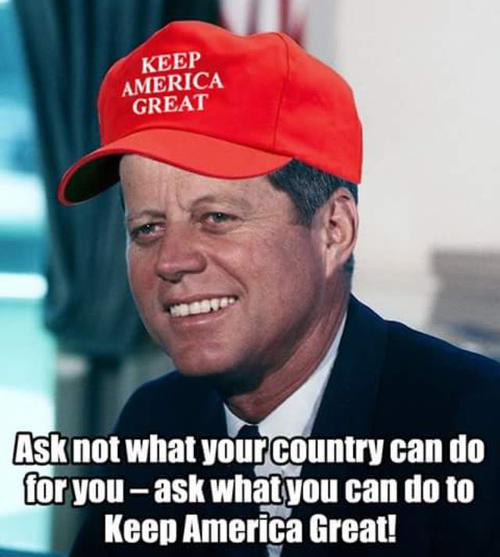

**Caption:** KEEP AMERICA GREAT Asknot what yourcountry can do for you-ask whatyou can do to Keep America Great! 

['OtherHate', 'NotHate', 'NotHate']


In [ ]:
print_image_and_caption(1024023264497152001)

In [ ]:
new_caption = find_caption_by_id(1024023264497152001)
new_X = vectorizer.transform([new_caption])
logreg_pred = logreg.predict(new_X)
nb_pred = nb.predict(new_X)

# Print the predicted labels side by side
print("Logistic Regression Prediction: ", CONVERSION[logreg_pred.item()])
print("Naive Bayes Prediction: ", CONVERSION[nb_pred.item()])

Logistic Regression Prediction:  OtherHate
Naive Bayes Prediction:  OtherHate


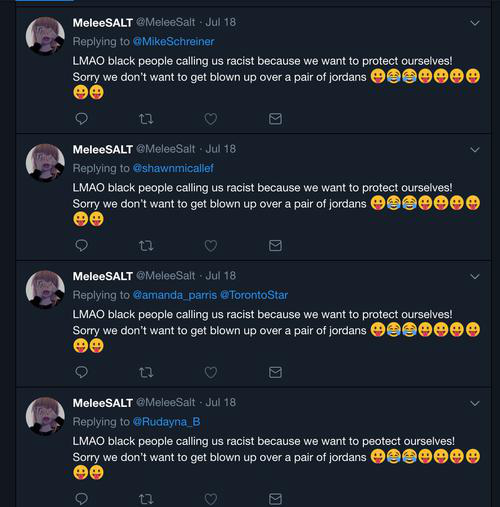

**Caption:** MeleeSALT MeleeSalt Jul 18 Replying to @MikeSchreiner LMAO black people calling us racist because we want to protect ourselves! Sorry we don't want to get blown up over a pair of jordanseee MeleeSALT MeleeSalt Jul 18 Replying to @shawnmicallef LMAO black people calling us racist because we want to protect ourselves! Sorry we don't want to get blown up over a pair of jordanseeee ta. MeleeSALT @MeleeSalt Jul 18 Replying to @amanda parris @TorontoStar LMAO black people calling us racist because we want to protect ourselves! Sorry we don't want to get blown up over a pair of jordanseeee MeleeSALT MeleeSalt Jul 18 Replying to @Rudayna B LMAO black people calling us racist because we want to peotect ourselves! Sorry we don't want to get blown up over a pair of jordans eee ta 

['OtherHate', 'Racist', 'Racist']


In [ ]:
print_image_and_caption(1024122734257872896)

In [ ]:
new_caption = find_caption_by_id(1024122734257872896)
new_X = vectorizer.transform([new_caption])
logreg_pred = logreg.predict(new_X)
nb_pred = nb.predict(new_X)

# Print the predicted labels side by side
print("Logistic Regression Prediction: ", CONVERSION[logreg_pred.item()])
print("Naive Bayes Prediction: ", CONVERSION[nb_pred.item()])

Logistic Regression Prediction:  OtherHate
Naive Bayes Prediction:  OtherHate


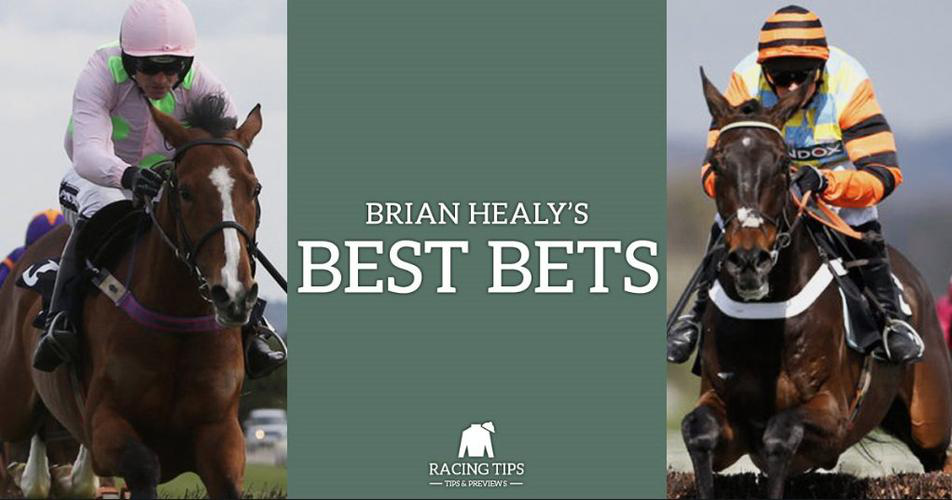

**Caption:** BRIAN HEALY'S BEST BETS RACING TIPS TIPS&PREVIEWS 

['NotHate', 'NotHate', 'NotHate']


In [ ]:
print_image_and_caption(1025083811946815488)

In [ ]:
new_caption = find_caption_by_id(1025083811946815488)
new_X = vectorizer.transform([new_caption])
logreg_pred = logreg.predict(new_X)
nb_pred = nb.predict(new_X)

# Print the predicted labels side by side
print("Logistic Regression Prediction: ", CONVERSION[logreg_pred.item()])
print("Naive Bayes Prediction: ", CONVERSION[nb_pred.item()])

Logistic Regression Prediction:  NotHate
Naive Bayes Prediction:  NotHate


TF-IDF

In [ ]:
# Load train, test, and validation data
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
val_df = pd.read_csv(VALID_CSV)

# Replace missing values with an empty string
train_df['Caption'] = train_df['Caption'].fillna('')
test_df['Caption'] = test_df['Caption'].fillna('')
val_df['Caption'] = val_df['Caption'].fillna('')

tfidf = TfidfVectorizer()
tfidf.fit(train_df['Caption'])

X_train = tfidf.transform(train_df['Caption'])
y_train = train_df['Label 1']

X_test = tfidf.transform(test_df['Caption'])
y_test = test_df['Label 1']

X_val = tfidf.transform(val_df['Caption'])
y_val = val_df['Label 1']

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

print("Logistic Regression accuracy on train set:", lr.score(X_train, y_train))
print("Logistic Regression accuracy on test set:", lr.score(X_test, y_test))
print("Logistic Regression accuracy on validation set:", lr.score(X_val, y_val))

Logistic Regression accuracy on train set: 0.7101173903228234
Logistic Regression accuracy on test set: 0.5321191238001477
Logistic Regression accuracy on validation set: 0.5376291195277915


In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

print("Naive Bayes accuracy on train set:", nb.score(X_train, y_train))
print("Naive Bayes accuracy on test set:", nb.score(X_test, y_test))
print("Naive Bayes accuracy on validation set:", nb.score(X_val, y_val))

Naive Bayes accuracy on train set: 0.70635487997592
Naive Bayes accuracy on test set: 0.5299040118139305
Naive Bayes accuracy on validation set: 0.5346778160354156


In [ ]:
filepaths = [TRAIN_CSV, TEST_CSV, VALID_CSV]

def find_caption_by_id(id):
    id_str = str(id)
    for filepath in filepaths:
        with open(filepath, encoding='utf-8') as csv_file:
            csv_reader = csv.reader(csv_file)
            headers = next(csv_reader, None)
            for row in csv_reader:
                if row[0] == id_str:
                    return row[1]
    return None

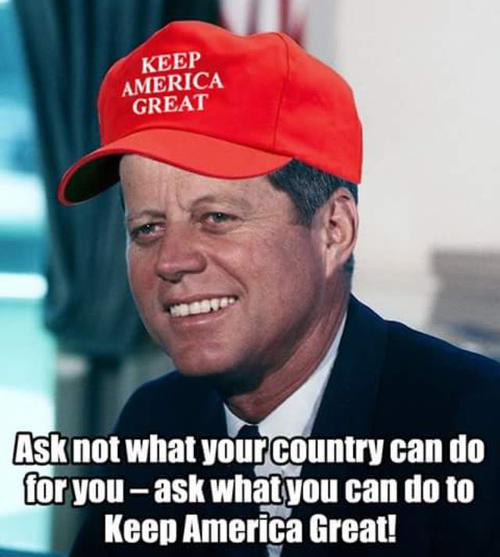

**Caption:** KEEP AMERICA GREAT Asknot what yourcountry can do for you-ask whatyou can do to Keep America Great! 

['OtherHate', 'NotHate', 'NotHate']


In [ ]:
print_image_and_caption(1024023264497152001)

In [ ]:
new_caption = find_caption_by_id(1024023264497152001)
new_X = vectorizer.transform([new_caption])
logreg_pred = lr.predict(new_X)
nb_pred = nb.predict(new_X)

# Print the predicted labels side by side
print("Logistic Regression Prediction: ", CONVERSION[logreg_pred.item()])
print("Naive Bayes Prediction: ", CONVERSION[nb_pred.item()])

Logistic Regression Prediction:  Sexist
Naive Bayes Prediction:  NotHate


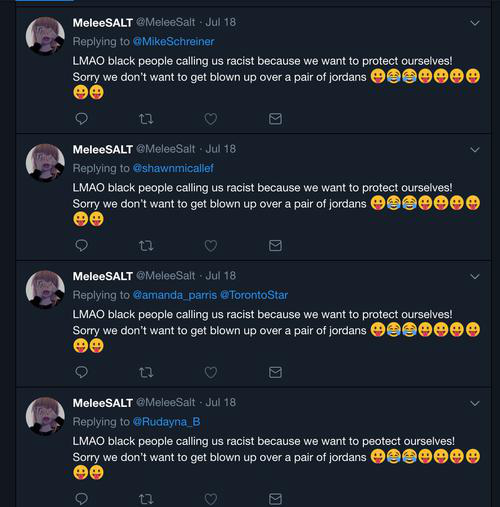

**Caption:** MeleeSALT MeleeSalt Jul 18 Replying to @MikeSchreiner LMAO black people calling us racist because we want to protect ourselves! Sorry we don't want to get blown up over a pair of jordanseee MeleeSALT MeleeSalt Jul 18 Replying to @shawnmicallef LMAO black people calling us racist because we want to protect ourselves! Sorry we don't want to get blown up over a pair of jordanseeee ta. MeleeSALT @MeleeSalt Jul 18 Replying to @amanda parris @TorontoStar LMAO black people calling us racist because we want to protect ourselves! Sorry we don't want to get blown up over a pair of jordanseeee MeleeSALT MeleeSalt Jul 18 Replying to @Rudayna B LMAO black people calling us racist because we want to peotect ourselves! Sorry we don't want to get blown up over a pair of jordans eee ta 

['OtherHate', 'Racist', 'Racist']


In [ ]:
print_image_and_caption(1024122734257872896)

In [ ]:
new_caption = find_caption_by_id(1024122734257872896)
new_X = vectorizer.transform([new_caption])
logreg_pred = lr.predict(new_X)
nb_pred = nb.predict(new_X)

# Print the predicted labels side by side
print("Logistic Regression Prediction: ", CONVERSION[logreg_pred.item()])
print("Naive Bayes Prediction: ", CONVERSION[nb_pred.item()])

Logistic Regression Prediction:  OtherHate
Naive Bayes Prediction:  NotHate


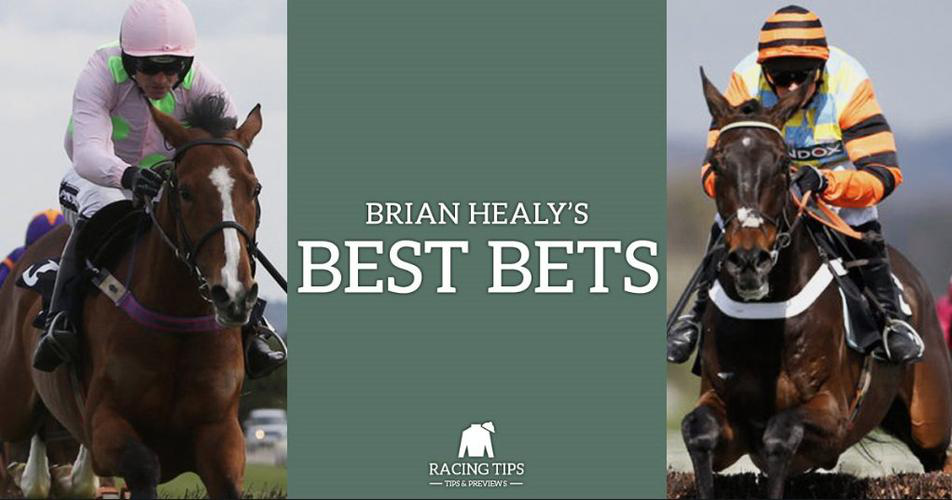

**Caption:** BRIAN HEALY'S BEST BETS RACING TIPS TIPS&PREVIEWS 

['NotHate', 'NotHate', 'NotHate']


In [ ]:
print_image_and_caption(1025083811946815488)

In [ ]:
new_caption = find_caption_by_id(1025083811946815488)
new_X = vectorizer.transform([new_caption])
logreg_pred = lr.predict(new_X)
nb_pred = nb.predict(new_X)

# Print the predicted labels side by side
print("Logistic Regression Prediction: ", CONVERSION[logreg_pred.item()])
print("Naive Bayes Prediction: ", CONVERSION[nb_pred.item()])

Logistic Regression Prediction:  NotHate
Naive Bayes Prediction:  NotHate


## Image Classification Model

In [ ]:
# Load data
train_df = pd.read_csv(TRAIN_CSV, header=0)
test_df = pd.read_csv(TEST_CSV, header=0)
val_df = pd.read_csv(VALID_CSV, header=0)

In [ ]:
# Preprocess image data
IMG_SIZE = (224, 224)
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Filepath",
    y_col="Label 1",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="raw"
)
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image Filepath",
    y_col="Label 1",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="raw"
)
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="Image Filepath",
    y_col="Label 1",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="raw"
)

Found 53156 validated image filenames.
Found 4063 validated image filenames.
Found 2033 validated image filenames.


In [ ]:
# Define model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SHAPE),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_generator, epochs=1, validation_data=val_generator)

1662/1662 [==============================] - 306s 183ms/step - loss: 0.6956 - accuracy: 0.7691 - val_loss: 1.7037 - val_accuracy: 0.5091


In [ ]:
# Print training and validation accuracy
print("Training accuracy:", history.history['accuracy'][-1])
print("Validation accuracy:", history.history['val_accuracy'][-1])

# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)

Training accuracy: 0.7690947651863098
Validation accuracy: 0.5090998411178589
127/127 [==============================] - 22s 176ms/step - loss: 1.7192 - accuracy: 0.5006
Test accuracy: 0.5006152987480164


In [ ]:
tf.saved_model.save(model, 'image_classifier_model')

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model
model = tf.saved_model.load('image_classifier_model')

# Define a function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img, dtype=np.float32)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Define a function to make a prediction
def predict(image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)

    # Make a prediction
    prediction = model(img_array)

    # Get the class with the highest probability
    predicted_class = tf.argmax(prediction[0]).numpy()

    return predicted_class

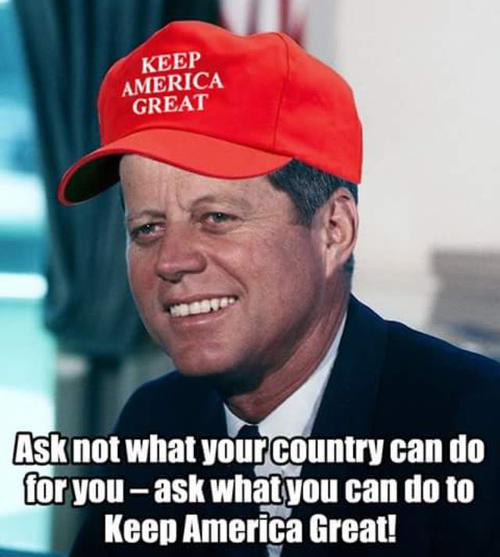

**Caption:** KEEP AMERICA GREAT Asknot what yourcountry can do for you-ask whatyou can do to Keep America Great! 

['OtherHate', 'NotHate', 'NotHate']


In [ ]:
print_image_and_caption(1024023264497152001)

In [ ]:
# Test the predict function on an image
image_path = '/1024023264497152001.jpg'
predicted_class = predict(IMAGES + image_path)
print('Predicted class:', predicted_class)
print('Predicted Type of Hate:', CONVERSION[predicted_class])

Predicted class: 5
Predicted Type of Hate: OtherHate


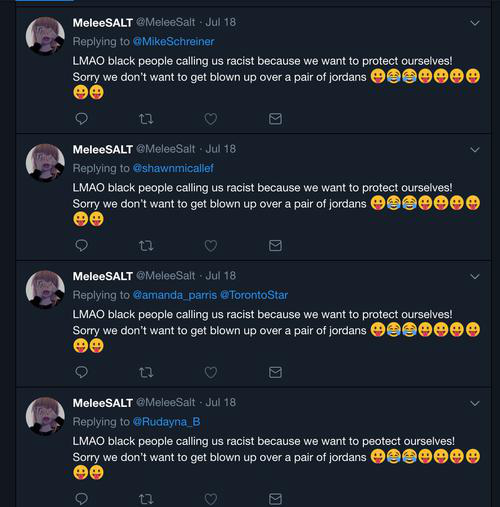

**Caption:** MeleeSALT MeleeSalt Jul 18 Replying to @MikeSchreiner LMAO black people calling us racist because we want to protect ourselves! Sorry we don't want to get blown up over a pair of jordanseee MeleeSALT MeleeSalt Jul 18 Replying to @shawnmicallef LMAO black people calling us racist because we want to protect ourselves! Sorry we don't want to get blown up over a pair of jordanseeee ta. MeleeSALT @MeleeSalt Jul 18 Replying to @amanda parris @TorontoStar LMAO black people calling us racist because we want to protect ourselves! Sorry we don't want to get blown up over a pair of jordanseeee MeleeSALT MeleeSalt Jul 18 Replying to @Rudayna B LMAO black people calling us racist because we want to peotect ourselves! Sorry we don't want to get blown up over a pair of jordans eee ta 

['OtherHate', 'Racist', 'Racist']


In [ ]:
print_image_and_caption(1024122734257872896)

In [ ]:
# Test the predict function on an image
image_path = '/1024122734257872896.jpg'
predicted_class = predict(IMAGES + image_path)
print('Predicted class:', predicted_class)
print('Predicted Type of Hate:', CONVERSION[predicted_class])

Predicted class: 0
Predicted Type of Hate: NotHate


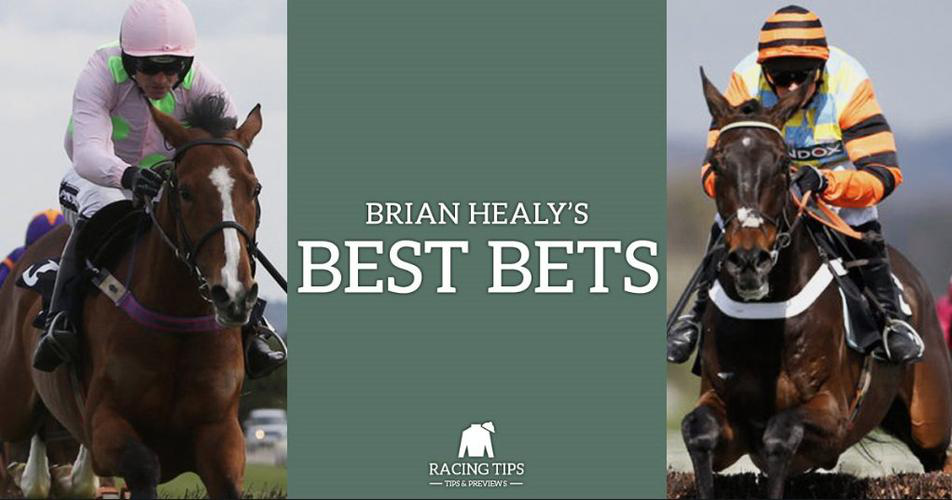

**Caption:** BRIAN HEALY'S BEST BETS RACING TIPS TIPS&PREVIEWS 

['NotHate', 'NotHate', 'NotHate']


In [ ]:
print_image_and_caption(1025083811946815488)

In [ ]:
# Test the predict function on an image
image_path = '/1025083811946815488.jpg'
predicted_class = predict(IMAGES + image_path)
print('Predicted class:', predicted_class)
print('Predicted Type of Hate:', CONVERSION[predicted_class])

Predicted class: 0
Predicted Type of Hate: NotHate


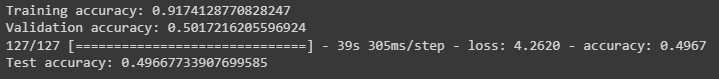

## Multi-Modal Classification Model

In [ ]:
# Imports
from keras.models import Model
from keras.layers import Input, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, load_img, img_to_array
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout
from keras.utils import to_categorical
import cv2
from tensorflow.python.client import device_lib

In [ ]:
# Ensure that GPU is being used for computations
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

print(device_lib.list_local_devices())

config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

tf.config.list_physical_devices('GPU')

! export CUDA_VISIBLE_DEVICES=0

os.environ['KERAS_BACKEND'] = 'tensorflow'

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4462704767953372137
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14343274496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2907905634339528609
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
# Checking if there is any NaN or float value in captions
def cleanup_nan_dataset(dataframe):
  indexWithFloat = []

  for index, value in enumerate(dataframe['Caption']):
    if type(value) == float:
      indexWithFloat.append(index)

  if len(indexWithFloat) > 0:
    print(f'{len(indexWithFloat)} VALUES FROM DATAFRAME CLEANED!')
    return dataframe.dropna()
  else:
    print('NO NAN VALUE FOUND. TRY AGAIN.')
    return

In [ ]:
# Preprocess the images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.
    return img

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VALID_CSV)
test_df = pd.read_csv(TEST_CSV)

train_split_df = pd.DataFrame()

# Split training data to only 5000 samples
for index in range(10000):
  data = train_df.iloc[index]
  train_split_df = train_split_df.append(data)

In [ ]:
# Clean up NaN values
train_df = cleanup_nan_dataset(train_split_df)
val_df = cleanup_nan_dataset(val_df)
test_df = cleanup_nan_dataset(test_df)

45 VALUES FROM DATAFRAME CLEANED!
9 VALUES FROM DATAFRAME CLEANED!
14 VALUES FROM DATAFRAME CLEANED!


In [ ]:
del train_split_df

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['Caption'])

train_seqs = tokenizer.texts_to_sequences(train_df['Caption'])
val_seqs = tokenizer.texts_to_sequences(val_df['Caption'])
test_seqs = tokenizer.texts_to_sequences(test_df['Caption'])

In [ ]:
# Checking actual amount of words in tokenizer
num_words = len(tokenizer.word_index) + 1
print(num_words)

26366


In [ ]:
# Finding max sequence size
max_size = 0

for array in train_seqs:
  if len(array) > max_size:
    max_size = len(array)

for array in val_seqs:
  if len(array) > max_size:
    max_size = len(array)

print(max_size)

265


In [ ]:
# Pad the sequences
max_seq_length = max_size

train_seqs = pad_sequences(train_seqs, maxlen=max_seq_length)
val_seqs = pad_sequences(val_seqs, maxlen=max_seq_length)
test_seqs = pad_sequences(test_seqs, maxlen=max_seq_length)

In [ ]:
# Adjusting the labels
train_labels_one_hot = to_categorical(train_df['Label 1'], num_classes=6)
val_labels_one_hot = to_categorical(val_df['Label 1'], num_classes=6)

In [ ]:
train_images = np.array([load_and_preprocess_image(img_path) for img_path in train_df['Image Filepath']])
val_images = np.array([load_and_preprocess_image(img_path) for img_path in val_df['Image Filepath']])
test_images = np.array([load_and_preprocess_image(img_path) for img_path in test_df['Image Filepath']])

In [ ]:
len(train_images[0][0])

224

In [ ]:
# Creating the model - Text

# Define the input shape for the text-based model
text_input = Input(shape=(max_seq_length,))

# Define the embedding layer
# vocab_size = 40000
vocab_size = num_words + 1000
embedding_dim = 100
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_seq_length)(text_input)

# Define the LSTM layer
lstm_units = 128
lstm_layer = LSTM(lstm_units)(embedding_layer)

lstm_layer = Flatten()(lstm_layer)
lstm_layer = Dropout(0.5)(lstm_layer)

In [ ]:
# Define the input shape for the image-based model
image_input_shape = (224, 224, 3)
image_input = Input(shape=image_input_shape)

# Define the CNN layers
conv_filters = 32
kernel_size = (3, 3)
pool_size = (2, 2)
cnn_layer = Conv2D(conv_filters, kernel_size, activation='relu')(image_input)
cnn_layer = MaxPooling2D(pool_size)(cnn_layer)
cnn_layer = Dropout(0.5)(cnn_layer)
cnn_layer = Conv2D(conv_filters, kernel_size, activation='relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size)(cnn_layer)
cnn_layer = Flatten()(cnn_layer)

In [ ]:
# Concatenate the outputs from the text-based and image-based models
combined_output = Concatenate()([lstm_layer, cnn_layer])

# Define the output layer
num_labels = 6
output_layer = Dense(num_labels, activation='softmax')(combined_output)

# Define the final model
model = Model(inputs=[text_input, image_input], outputs=output_layer)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
batch_size = 32
epochs = 1

model.fit([train_seqs, train_images], train_labels_one_hot, 
          validation_data=([val_seqs, val_images], val_labels_one_hot),
          batch_size=batch_size, epochs=epochs)

312/312 [==============================] - 65s 160ms/step - loss: 1.1002 - accuracy: 0.7006 - val_loss: 1.3446 - val_accuracy: 0.5339


Previous Training Results
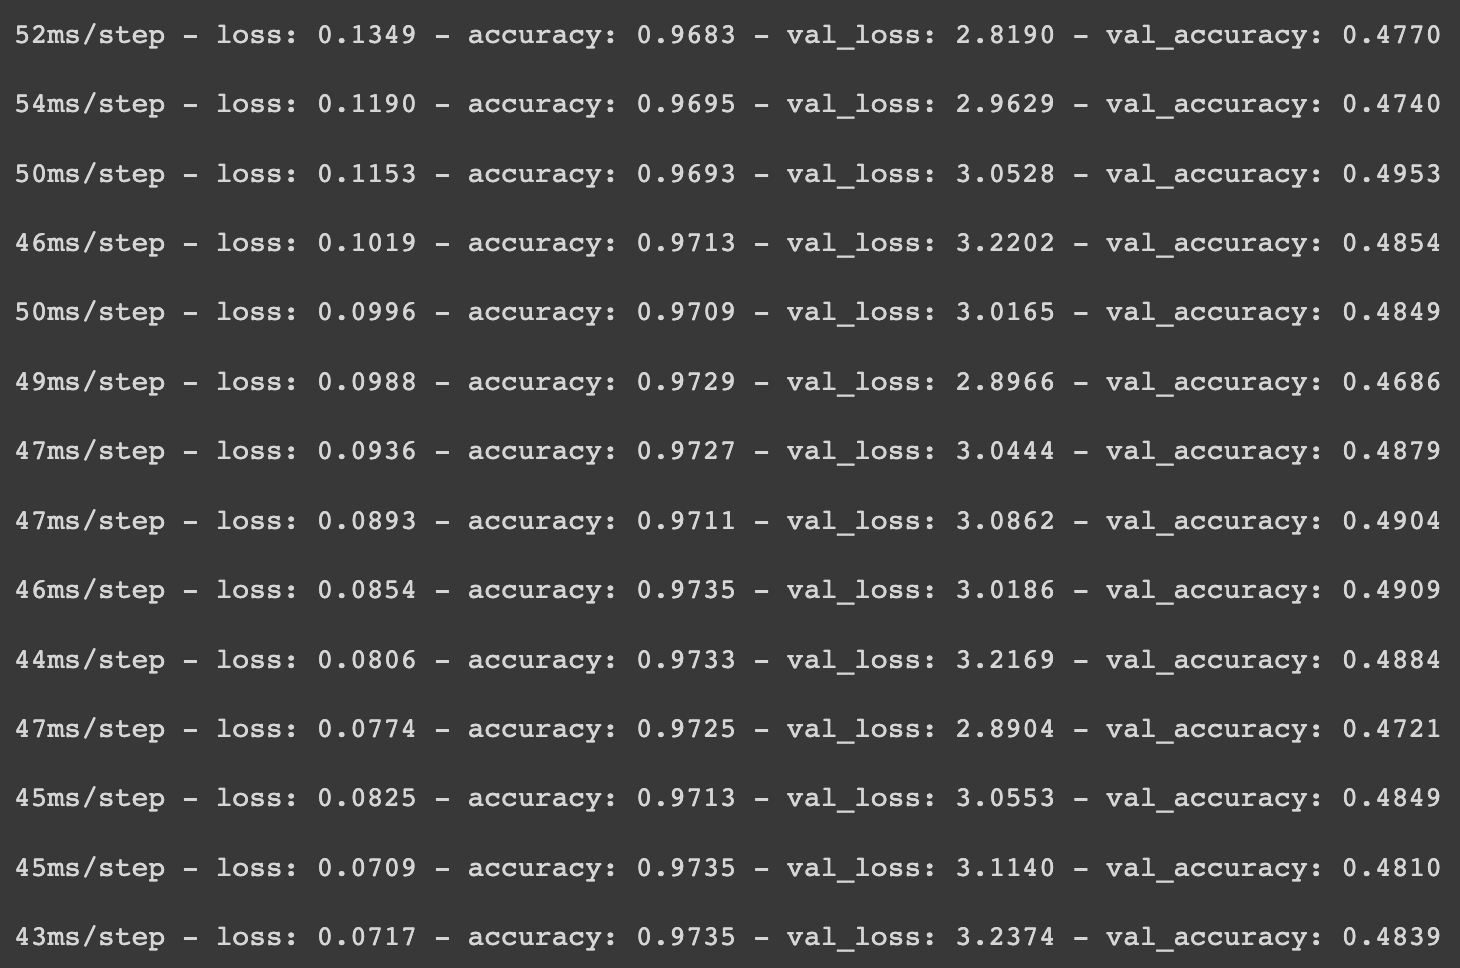

In [ ]:
def getPredictionData(index):
  # Tokenize the new caption
  new_caption = test_df['Caption'][index]
  new_caption_tokens = tokenizer.texts_to_sequences([new_caption])
  new_caption_tokens_padded = pad_sequences(new_caption_tokens, maxlen=max_size)

  # Load the image
  new_image_path = test_df['Image Filepath'][index]
  new_image = cv2.imread(new_image_path)
  new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
  new_image_resized = cv2.resize(new_image, (224, 224))

  return new_caption_tokens_padded, np.array([new_image_resized])

In [ ]:
# Test 1
captionData, imageData = getPredictionData(0)

In [ ]:
# Make the prediction
prediction = model.predict([captionData, imageData])

1/1 [==============================] - 0s 465ms/step


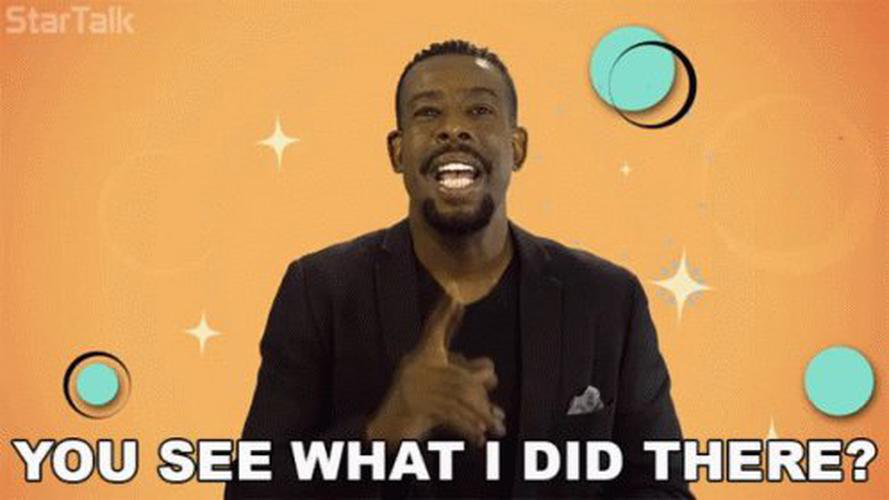

**Caption:** StarTall YOU SEE WHAT I DID THERE? 0 

['NotHate', 'NotHate', 'NotHate']


In [ ]:
print_image_and_caption(test_df['ID'][0])

In [ ]:
# Decode the prediction
predicted_label_index = np.argmax(prediction)

print("Predicted label: ", CONVERSION[predicted_label_index])

Predicted label:  NotHate


In [ ]:
# Test 2
captionData, imageData = getPredictionData(1)

# Make the prediction
prediction = model.predict([captionData, imageData])

1/1 [==============================] - 0s 23ms/step


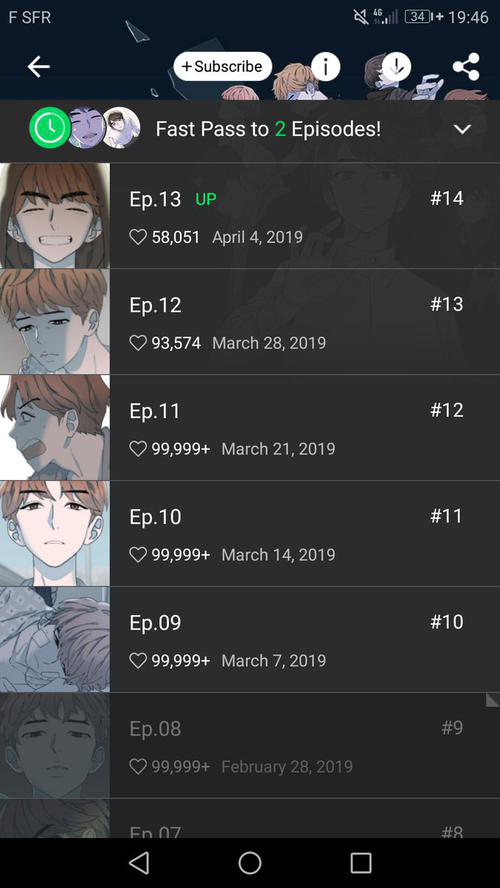

**Caption:** 34+ 19:46 F SFR + Subscribe Fast Pass to 2 Episodes! Ep.13 UP #14 58,051 April 4, 2019 #13 Ep.12 93,574 March 28, 2019 Ep.11 #12 99,999+ March 21, 2019 #11 Ep.10 99,999+ March 14, 2019 Ep.09 #10 99,999+ March 7, 2019 Ep.08 99,999+ February 28, 2019 #9 #8 En 07 

['OtherHate', 'NotHate', 'Racist']


In [ ]:
print_image_and_caption(test_df['ID'][1])

In [ ]:
# Decode the prediction
predicted_label_index = np.argmax(prediction)

print("Predicted label: ", CONVERSION[predicted_label_index])

Predicted label:  NotHate


In [ ]:
# Test 3
captionData, imageData = getPredictionData(3)

# Make the prediction
prediction = model.predict([captionData, imageData])

1/1 [==============================] - 0s 24ms/step


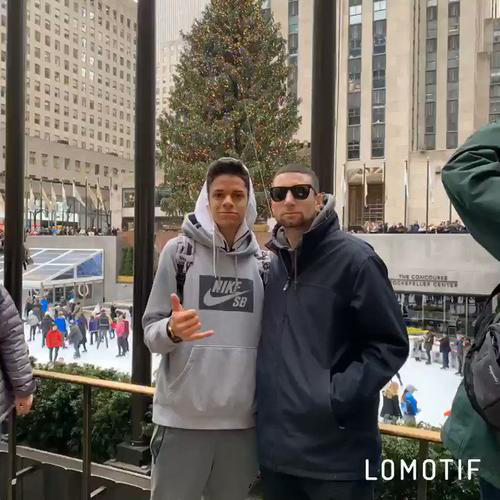

**Caption:** LOMOTI 

['NotHate', 'NotHate', 'Racist']


In [ ]:
print_image_and_caption(test_df['ID'][3])

In [ ]:
# Decode the prediction
predicted_label_index = np.argmax(prediction)

print("Predicted label: ", CONVERSION[predicted_label_index])

Predicted label:  NotHate
